# Задача 9. Сравнение методов регрессии


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
import warnings

warnings.filterwarnings("ignore")
plt.style.use("default")


## Блок 1: Загрузка и первичный анализ данных

В этом блоке выполняется:
- Загрузка датасета California Housing
- Первичный анализ данных (размер, типы данных, пропуски)
- Базовая статистика


In [2]:
california_housing = fetch_california_housing()
df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df["target"] = california_housing.target

print("Датасет California Housing загружен")
print("Размер датасета:", df.shape)
print("\nСтолбцы:", df.columns.tolist())
print("\nПервые 5 строк:")
df.head()


Датасет California Housing загружен
Размер датасета: (20640, 9)

Столбцы: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'target']

Первые 5 строк:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB

Описательная статистика:


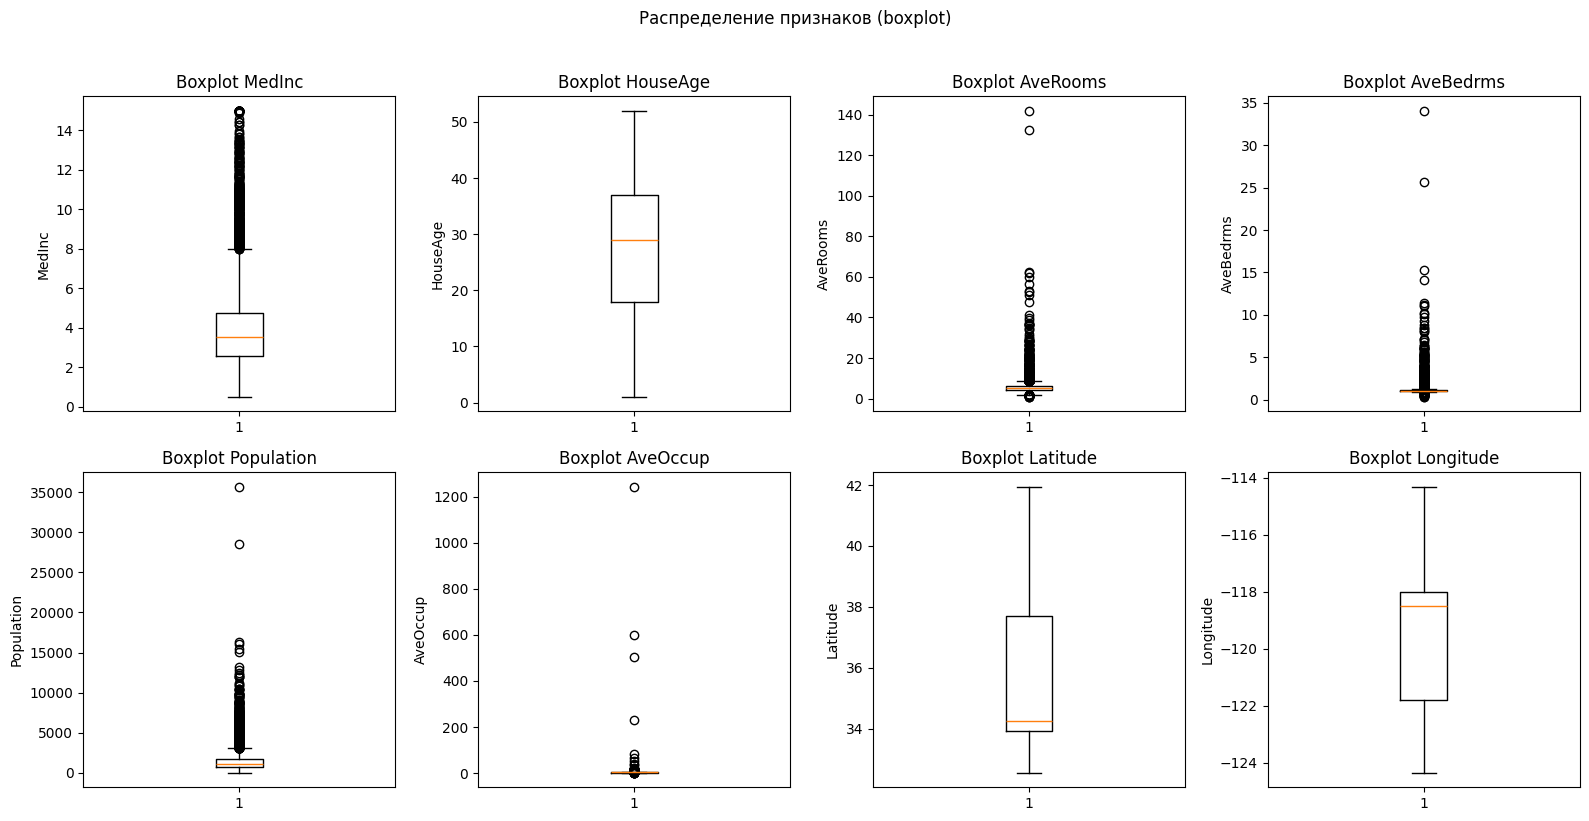

In [3]:
print("Информация о данных:")
df.info()
print("\nОписательная статистика:")
df.describe()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):
    axes[i].boxplot(df[col], vert=True)
    axes[i].set_title(f"Boxplot {col}")
    axes[i].set_ylabel(col)

plt.suptitle("Распределение признаков (boxplot)", y=1.02)
plt.tight_layout()
plt.show()


In [4]:
print("Проверка пропущенных значений:")
print(df.isnull().sum())
print("\nПроверка дубликатов:")
print(f"Количество дубликатов: {df.duplicated().sum()}")

plt.figure(figsize=(10, 6))
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    missing_data = missing_data[missing_data > 0]
    plt.bar(missing_data.index, missing_data.values)
    plt.title("Распределение пропущенных значений по признакам")
    plt.xlabel("Признаки")
    plt.ylabel("Количество пропущенных значений")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nГрафик пропущенных значений: пропущенных значений нет")


Проверка пропущенных значений:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

Проверка дубликатов:
Количество дубликатов: 0

График пропущенных значений: пропущенных значений нет


<Figure size 1000x600 with 0 Axes>

### Мини-выводы блока 1:

- Датасет California Housing успешно загружен: 20,640 записей с 8 признаками и целевой переменной
- Все данные числового типа (float64), пропущенных значений и дубликатов нет
- Данные готовы для дальнейшего анализа и обработки

## Блок 2: Data Cleaning

В этом блоке выполняется очистка данных:
- Обработка пропущенных значений
- Обработка выбросов (если необходимо)


Проверка пропущенных значений после копирования:
0

Пропущенных значений нет


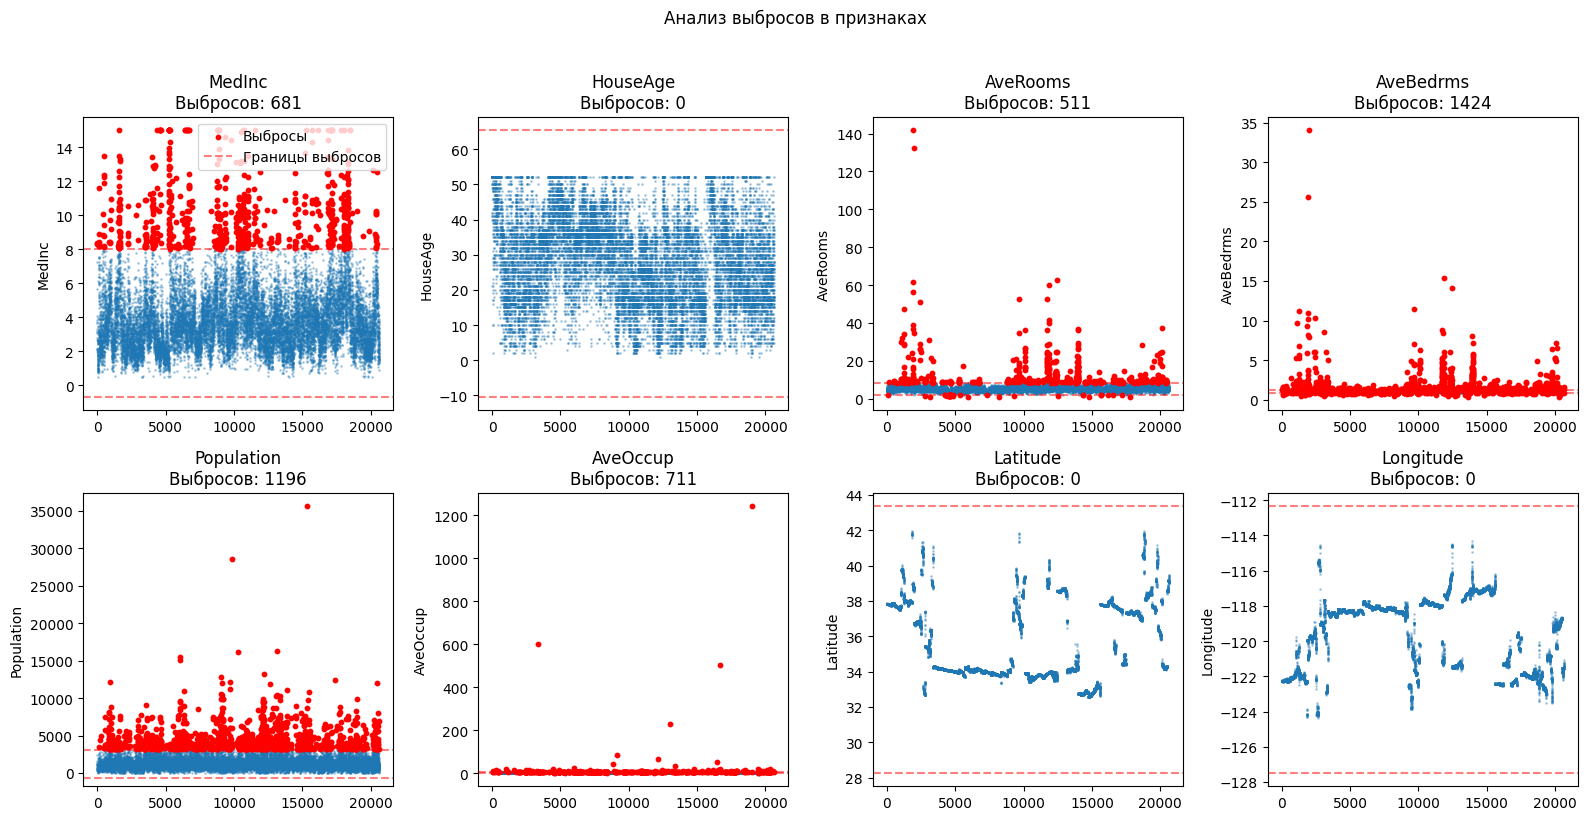

In [5]:
df_clean = df.copy()

print("Проверка пропущенных значений после копирования:")
print(df_clean.isnull().sum().sum())

if df_clean.isnull().sum().sum() > 0:
    print("\nЗаполняем пропущенные значения медианой:")
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    print("Пропущенные значения обработаны")
else:
    print("\nПропущенных значений нет")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df_clean.columns[:-1]):
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    
    axes[i].scatter(range(len(df_clean)), df_clean[col], alpha=0.3, s=1)
    if len(outliers) > 0:
        outlier_indices = outliers.index
        axes[i].scatter(outlier_indices, outliers[col], color='red', s=10, label='Выбросы')
    axes[i].axhline(y=lower_bound, color='r', linestyle='--', alpha=0.5, label='Границы выбросов')
    axes[i].axhline(y=upper_bound, color='r', linestyle='--', alpha=0.5)
    axes[i].set_title(f"{col}\nВыбросов: {len(outliers)}")
    axes[i].set_ylabel(col)
    if i == 0:
        axes[i].legend()

plt.suptitle("Анализ выбросов в признаках", y=1.02)
plt.tight_layout()
plt.show()


### Мини-выводы блока 2:

- Пропущенных значений в данных нет, дополнительная обработка не требуется
- В признаках обнаружены выбросы, что характерно для реальных данных
- Выбросы могут влиять на качество моделей, но их удаление не требуется на данном этапе

## Блок 3: Разведочный анализ данных (EDA)

В этом блоке выполняется разведочный анализ:
- Визуализация распределений признаков
- Анализ корреляций
- Визуализация взаимосвязей между признаками и целевой переменной


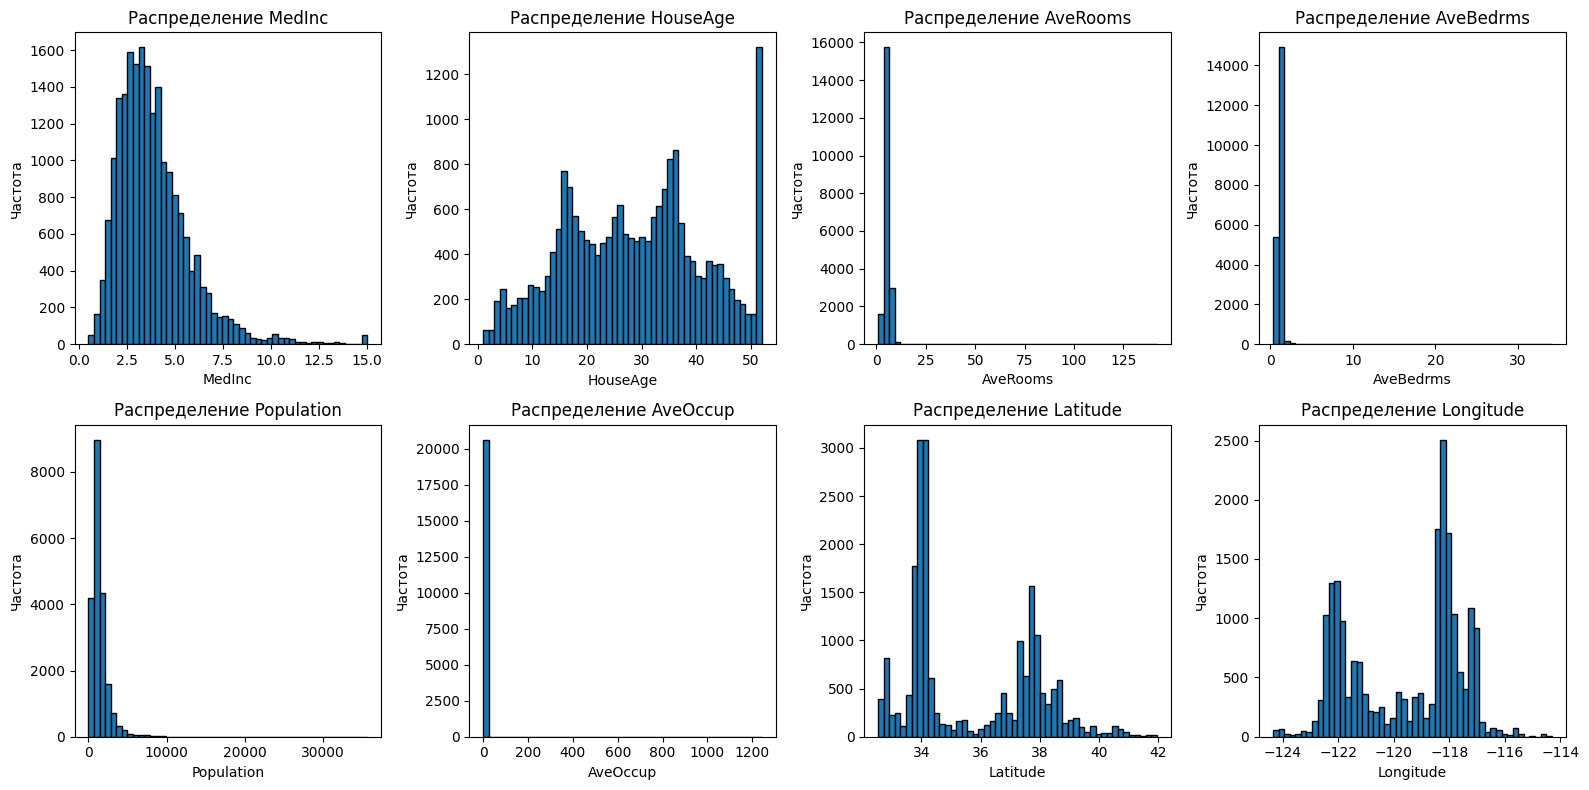

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df_clean.columns[:-1]):
    axes[i].hist(df_clean[col], bins=50, edgecolor="black")
    axes[i].set_title(f"Распределение {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Частота")

plt.tight_layout()
plt.show()


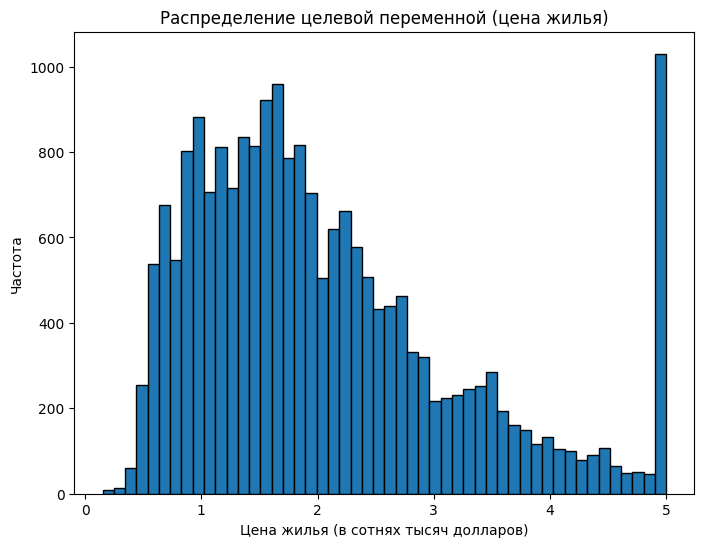

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(df_clean["target"], bins=50, edgecolor="black")
plt.title("Распределение целевой переменной (цена жилья)")
plt.xlabel("Цена жилья (в сотнях тысяч долларов)")
plt.ylabel("Частота")
plt.show()


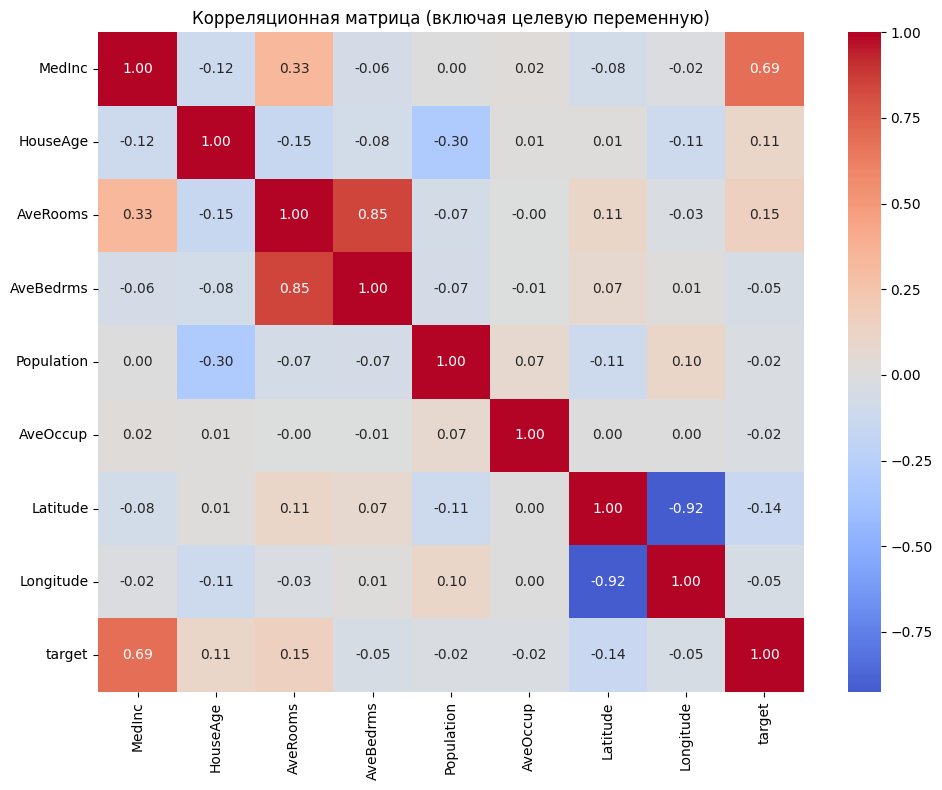

In [8]:
correlation_matrix = df_clean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляционная матрица (включая целевую переменную)")
plt.tight_layout()
plt.show()


Корреляция признаков с целевой переменной:
target        1.000000
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: target, dtype: float64


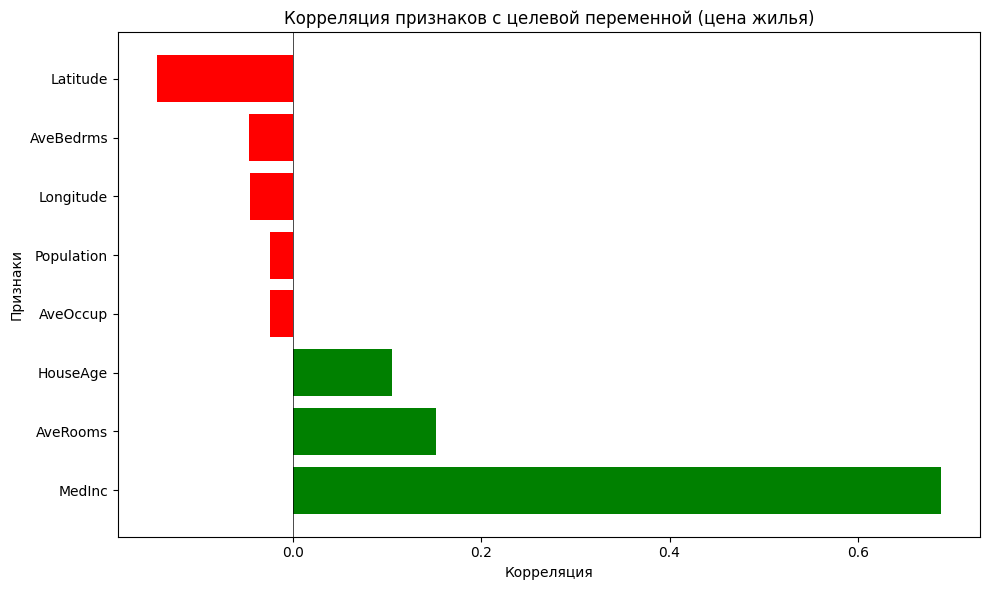

In [9]:
target_corr = df_clean.corr()["target"].sort_values(ascending=False)
print("Корреляция признаков с целевой переменной:")
print(target_corr)

plt.figure(figsize=(10, 6))
target_corr_without_target = target_corr.drop("target")
colors = ['red' if x < 0 else 'green' for x in target_corr_without_target.values]
plt.barh(target_corr_without_target.index, target_corr_without_target.values, color=colors)
plt.title("Корреляция признаков с целевой переменной (цена жилья)")
plt.xlabel("Корреляция")
plt.ylabel("Признаки")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


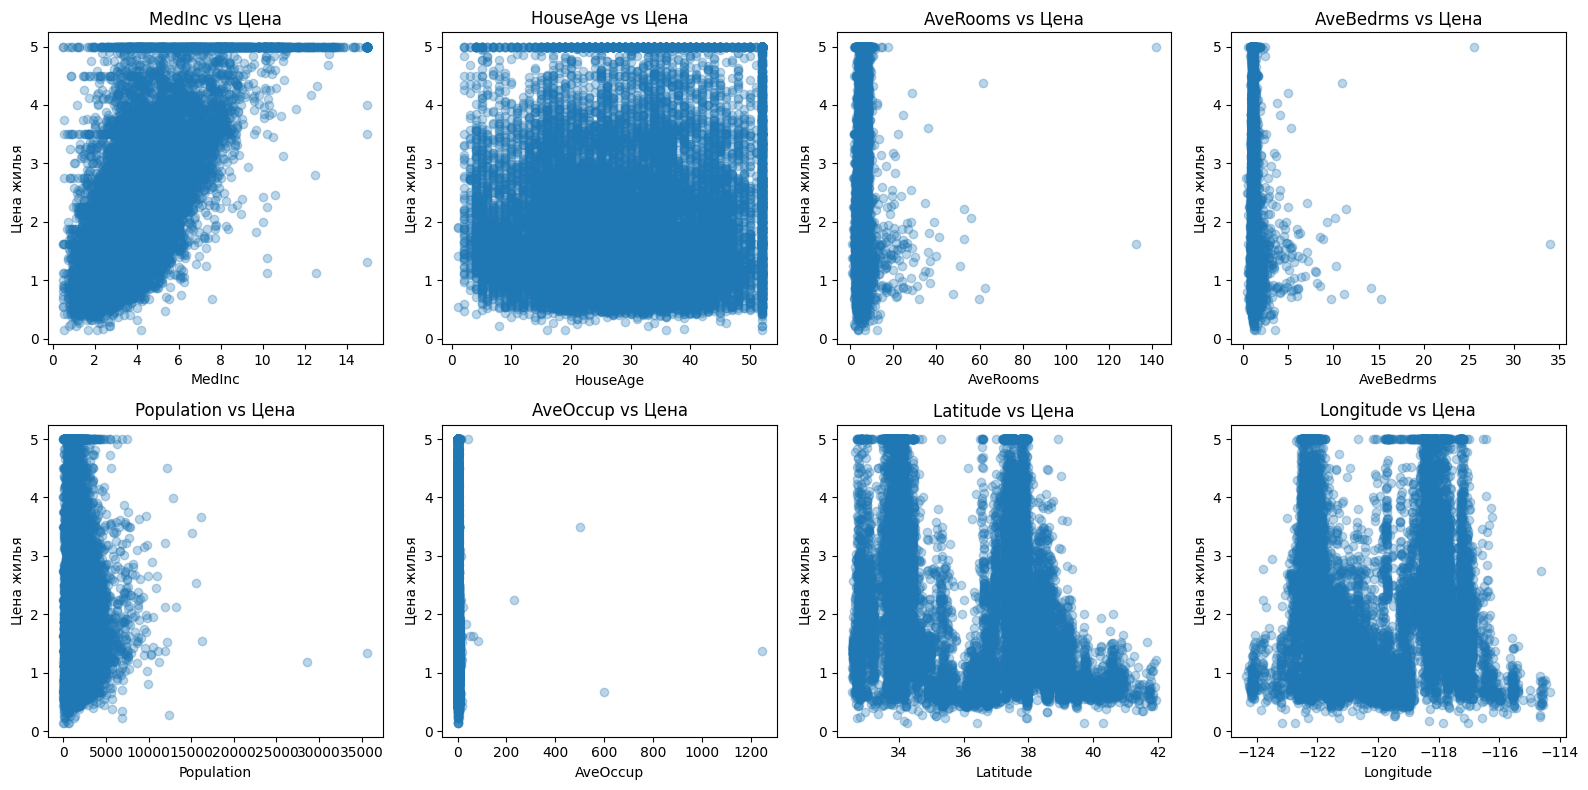

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df_clean.columns[:-1]):
    axes[i].scatter(df_clean[col], df_clean["target"], alpha=0.3)
    axes[i].set_title(f"{col} vs Цена")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Цена жилья")

plt.tight_layout()
plt.show()


### Мини-выводы блока 3:

- Наибольшая корреляция с целевой переменной у признака MedInc (0.688) - медианный доход
- Распределение целевой переменной близко к нормальному с небольшим правым хвостом
- Признаки показывают различную степень корреляции с ценой жилья, что указывает на возможность построения качественной модели

## Блок 4: Feature Engineering

В этом блоке выполняется инженерия признаков:
- Преобразование категориальных признаков (если есть)
- Создание новых признаков (если необходимо)
- Удаление ненужных признаков


Созданы новые признаки:
- rooms_per_household
- bedrooms_per_room
- population_per_household

Новые столбцы:
   rooms_per_household  bedrooms_per_room  population_per_household
0             1.964286           0.128231                  7.666667
1             2.005934           0.134272                109.136364
2             2.179792           0.115572                  9.358491
3             1.639640           0.157401                 10.528302
4             1.974515           0.148462                 10.660377


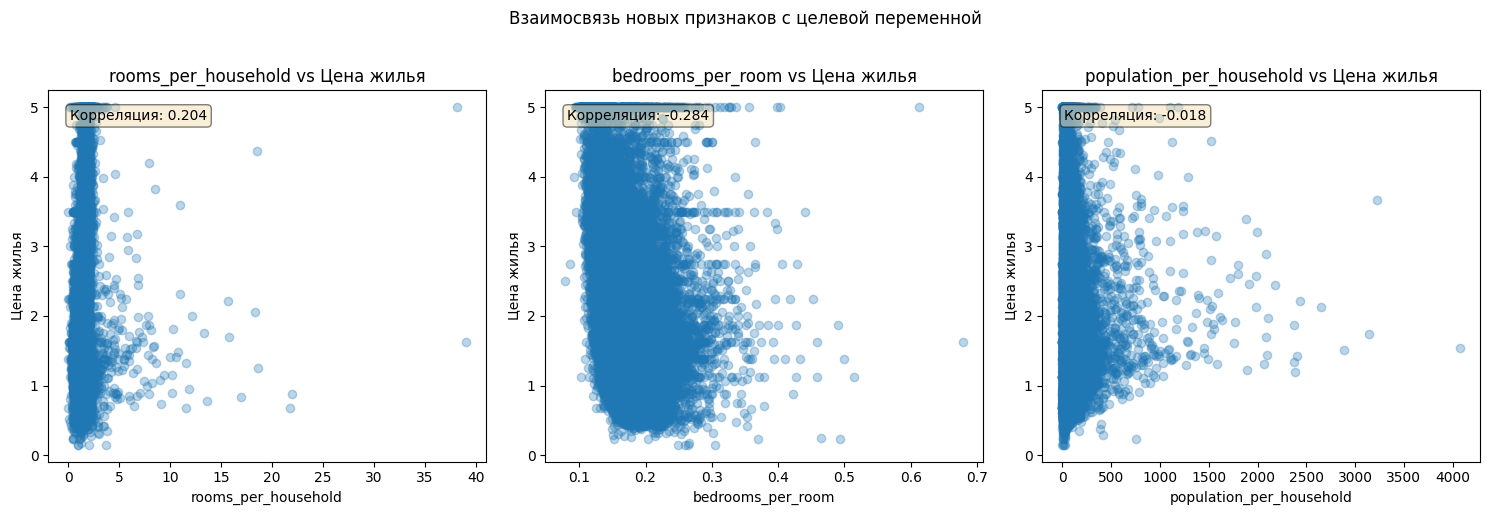

In [11]:
df_features = df_clean.copy()

df_features["rooms_per_household"] = df_features["AveRooms"] / (
    df_features["AveOccup"] + 1
)
df_features["bedrooms_per_room"] = df_features["AveBedrms"] / (
    df_features["AveRooms"] + 1
)
df_features["population_per_household"] = df_features["Population"] / (
    df_features["HouseAge"] + 1
)

print("Созданы новые признаки:")
print("- rooms_per_household")
print("- bedrooms_per_room")
print("- population_per_household")
print("\nНовые столбцы:")
print(df_features[["rooms_per_household", "bedrooms_per_room", "population_per_household"]].head())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

new_features = ["rooms_per_household", "bedrooms_per_room", "population_per_household"]
for i, feat in enumerate(new_features):
    axes[i].scatter(df_features[feat], df_features["target"], alpha=0.3)
    axes[i].set_title(f"{feat} vs Цена жилья")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("Цена жилья")
    
    corr = df_features[feat].corr(df_features["target"])
    axes[i].text(0.05, 0.95, f"Корреляция: {corr:.3f}", 
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle("Взаимосвязь новых признаков с целевой переменной", y=1.02)
plt.tight_layout()
plt.show()


и вс

In [12]:
X = df_features.drop("target", axis=1)
y = df_features["target"]

print("Признаки для моделирования:")
print(X.columns.tolist())
print(f"\nРазмер признаков: {X.shape}")
print(f"Размер целевой переменной: {y.shape}")
print(f"\nСтатистика целевой переменной:")
print(y.describe())


Признаки для моделирования:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']

Размер признаков: (20640, 11)
Размер целевой переменной: (20640,)

Статистика целевой переменной:
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: target, dtype: float64


### Мини-выводы блока 4:

- Созданы 3 новых признака: rooms_per_household, bedrooms_per_room, population_per_household
- Новые признаки показывают различную корреляцию с целевой переменной
- Количество признаков увеличено с 8 до 11, что может улучшить качество моделей

## Блок 5: Подготовка данных для обучения

В этом блоке выполняется:
- Разделение данных на обучающую и тестовую выборки
- Масштабирование признаков


Размер обучающей выборки: 16512 (80.0%)
Размер тестовой выборки: 4128 (20.0%)

Статистика целевой переменной (обучающая выборка):
count    16512.000000
mean         2.071947
std          1.156226
min          0.149990
25%          1.198000
50%          1.798500
75%          2.651250
max          5.000010
Name: target, dtype: float64

Статистика целевой переменной (тестовая выборка):
count    4128.000000
mean        2.055003
std         1.144870
min         0.149990
25%         1.192750
50%         1.786500
75%         2.630000
max         5.000010
Name: target, dtype: float64


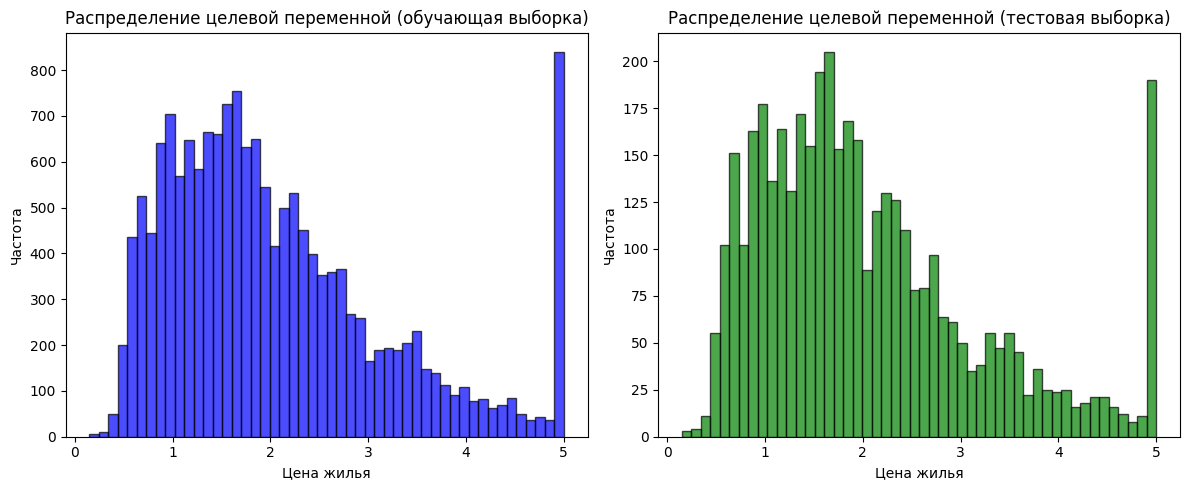

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Размер тестовой выборки: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nСтатистика целевой переменной (обучающая выборка):")
print(y_train.describe())
print(f"\nСтатистика целевой переменной (тестовая выборка):")
print(y_test.describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_train, bins=50, edgecolor="black", alpha=0.7, color='blue')
axes[0].set_title("Распределение целевой переменной (обучающая выборка)")
axes[0].set_xlabel("Цена жилья")
axes[0].set_ylabel("Частота")

axes[1].hist(y_test, bins=50, edgecolor="black", alpha=0.7, color='green')
axes[1].set_title("Распределение целевой переменной (тестовая выборка)")
axes[1].set_xlabel("Цена жилья")
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()


In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Данные масштабированы")
print("\nСтатистика масштабированных данных (обучающая выборка):")
print(X_train_scaled.describe())


Данные масштабированы

Статистика масштабированных данных (обучающая выборка):
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  1.651200e+04  1.651200e+04  1.651200e+04  1.651200e+04  1.651200e+04   
mean  -6.519333e-17 -9.251859e-18 -1.981081e-16 -1.707291e-16 -2.151595e-19   
std    1.000030e+00  1.000030e+00  1.000030e+00  1.000030e+00  1.000030e+00   
min   -1.775438e+00 -2.190766e+00 -1.904386e+00 -1.762117e+00 -1.251913e+00   
25%   -6.900689e-01 -8.417859e-01 -4.118373e-01 -2.081645e-01 -5.606339e-01   
50%   -1.758995e-01  3.108328e-02 -8.350905e-02 -1.094160e-01 -2.281865e-01   
75%    4.686502e-01  6.658972e-01  2.621376e-01  8.455177e-03  2.634487e-01   
max    5.839268e+00  1.856173e+00  5.716655e+01  5.664727e+01  3.012743e+01   

           AveOccup      Latitude     Longitude  rooms_per_household  \
count  1.651200e+04  1.651200e+04  1.651200e+04         1.651200e+04   
mean   4.936566e-17  6.400995e-17  1.753335e-15         2.035947e

### Мини-выводы блока 5:

- Данные разделены на обучающую (80%) и тестовую (20%) выборки
- Распределение целевой переменной в обеих выборках схоже, что важно для корректной оценки моделей
- Признаки масштабированы с помощью StandardScaler для линейных моделей

## Блок 6: Обучение моделей регрессии

В этом блоке выполняется:
- Обучение четырех методов регрессии с подбором гиперпараметров через GridSearchCV
- Использование кросс-валидации для оценки качества
- Модели: Linear Regression, Ridge Regression, Random Forest, Gradient Boosting


In [15]:
models = {}
results = {}

param_grids = {
    "Ridge": {
        "alpha": [0.1, 1, 10, 100],
    },
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
    },
}

print("Начинаем обучение моделей с подбором гиперпараметров...")


Начинаем обучение моделей с подбором гиперпараметров...


In [16]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
models["LinearRegression"] = lr
results["LinearRegression"] = {}

print("Linear Regression обучена")


Linear Regression обучена


In [17]:
ridge = Ridge(random_state=42)
ridge_grid = GridSearchCV(
    ridge, param_grids["Ridge"], cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)
ridge_grid.fit(X_train_scaled, y_train)
models["Ridge"] = ridge_grid.best_estimator_
results["Ridge"] = {
    "best_params": ridge_grid.best_params_,
    "best_cv_score": -ridge_grid.best_score_,
}

print("Ridge Regression обучена")
print(f"Лучшие параметры: {ridge_grid.best_params_}")
print(f"Лучший CV MSE: {results['Ridge']['best_cv_score']:.4f}")


Ridge Regression обучена
Лучшие параметры: {'alpha': 10}
Лучший CV MSE: 0.4482


In [18]:
rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(
    rf, param_grids["RandomForest"], cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)
rf_grid.fit(X_train, y_train)
models["RandomForest"] = rf_grid.best_estimator_
results["RandomForest"] = {
    "best_params": rf_grid.best_params_,
    "best_cv_score": -rf_grid.best_score_,
}

print("Random Forest обучена")
print(f"Лучшие параметры: {rf_grid.best_params_}")
print(f"Лучший CV MSE: {results['RandomForest']['best_cv_score']:.4f}")


Random Forest обучена
Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Лучший CV MSE: 0.2631


In [19]:
gb = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(
    gb, param_grids["GradientBoosting"], cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)
gb_grid.fit(X_train, y_train)
models["GradientBoosting"] = gb_grid.best_estimator_
results["GradientBoosting"] = {
    "best_params": gb_grid.best_params_,
    "best_cv_score": -gb_grid.best_score_,
}

print("Gradient Boosting обучена")
print(f"Лучшие параметры: {gb_grid.best_params_}")
print(f"Лучший CV MSE: {results['GradientBoosting']['best_cv_score']:.4f}")


Gradient Boosting обучена
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Лучший CV MSE: 0.2222


### Мини-выводы блока 6:

- Обучены 4 модели регрессии: Linear Regression, Ridge, Random Forest, Gradient Boosting
- Для Ridge, Random Forest и Gradient Boosting выполнен подбор гиперпараметров через GridSearchCV
- Gradient Boosting показал наилучший CV MSE (0.2222), Random Forest - 0.2631, Ridge - 0.4482

## Блок 7: Сравнение моделей

В этом блоке выполняется:
- Оценка качества моделей на тестовой выборке
- Измерение времени обучения и предсказания
- Сравнение метрик (RMSE, R², MAE)


In [20]:
test_results = {}

for name, model in models.items():
    if name in ["LinearRegression", "Ridge"]:
        start_time = time.time()
        y_pred = model.predict(X_test_scaled)
        pred_time = time.time() - start_time
    else:
        start_time = time.time()
        y_pred = model.predict(X_test)
        pred_time = time.time() - start_time

    test_results[name] = {
        "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
        "r2": r2_score(y_test, y_pred),
        "mae": mean_absolute_error(y_test, y_pred),
        "predictions": y_pred,
        "prediction_time": pred_time,
    }

    print(f"\n{name}:")
    print(f"  RMSE: {test_results[name]['rmse']:.4f}")
    print(f"  R²: {test_results[name]['r2']:.4f}")
    print(f"  MAE: {test_results[name]['mae']:.4f}")
    print(f"  Время предсказания: {test_results[name]['prediction_time']:.4f} сек")



LinearRegression:
  RMSE: 0.6746
  R²: 0.6527
  MAE: 0.4840
  Время предсказания: 0.0054 сек

Ridge:
  RMSE: 0.6746
  R²: 0.6528
  MAE: 0.4839
  Время предсказания: 0.0008 сек

RandomForest:
  RMSE: 0.5054
  R²: 0.8050
  MAE: 0.3288
  Время предсказания: 0.2298 сек

GradientBoosting:
  RMSE: 0.4704
  R²: 0.8311
  MAE: 0.3112
  Время предсказания: 0.0145 сек


In [21]:
train_times = {}

for name, model in models.items():
    if name in ["LinearRegression", "Ridge"]:
        start_time = time.time()
        if name == "LinearRegression":
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train_scaled, y_train)
        train_time = time.time() - start_time
    else:
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

    train_times[name] = train_time
    test_results[name]["training_time"] = train_time

    print(f"{name} - Время обучения: {train_time:.4f} сек")


LinearRegression - Время обучения: 0.0185 сек
Ridge - Время обучения: 0.0062 сек
RandomForest - Время обучения: 23.9150 сек
GradientBoosting - Время обучения: 13.4980 сек


In [22]:
comparison_df = pd.DataFrame(
    {
        "Model": list(test_results.keys()),
        "RMSE": [test_results[m]["rmse"] for m in test_results.keys()],
        "R²": [test_results[m]["r2"] for m in test_results.keys()],
        "MAE": [test_results[m]["mae"] for m in test_results.keys()],
        "Training Time (s)": [test_results[m]["training_time"] for m in test_results.keys()],
        "Prediction Time (s)": [test_results[m]["prediction_time"] for m in test_results.keys()],
    }
)

print("Сравнение моделей:")
print(comparison_df.to_string(index=False))


Сравнение моделей:
           Model     RMSE       R²      MAE  Training Time (s)  Prediction Time (s)
LinearRegression 0.674645 0.652669 0.483970           0.018474             0.005369
           Ridge 0.674560 0.652757 0.483923           0.006162             0.000805
    RandomForest 0.505448 0.805040 0.328766          23.914988             0.229826
GradientBoosting 0.470404 0.831137 0.311165          13.497960             0.014486


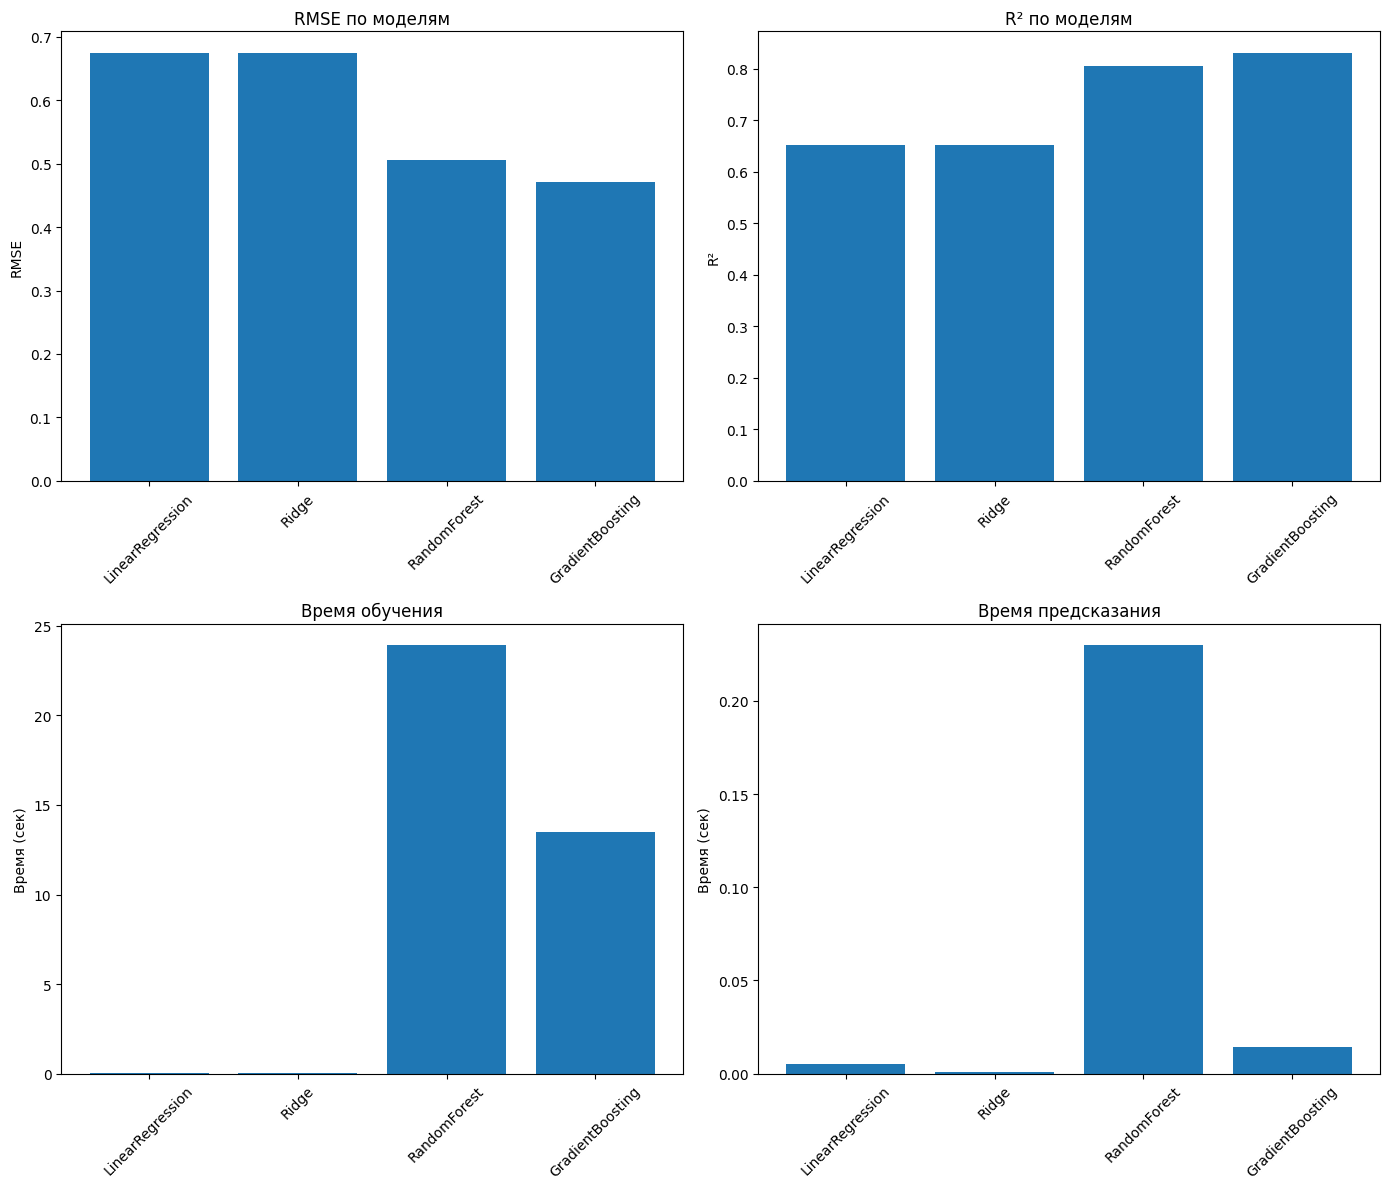

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].bar(comparison_df["Model"], comparison_df["RMSE"])
axes[0, 0].set_title("RMSE по моделям")
axes[0, 0].set_ylabel("RMSE")
axes[0, 0].tick_params(axis="x", rotation=45)

axes[0, 1].bar(comparison_df["Model"], comparison_df["R²"])
axes[0, 1].set_title("R² по моделям")
axes[0, 1].set_ylabel("R²")
axes[0, 1].tick_params(axis="x", rotation=45)

axes[1, 0].bar(comparison_df["Model"], comparison_df["Training Time (s)"])
axes[1, 0].set_title("Время обучения")
axes[1, 0].set_ylabel("Время (сек)")
axes[1, 0].tick_params(axis="x", rotation=45)

axes[1, 1].bar(comparison_df["Model"], comparison_df["Prediction Time (s)"])
axes[1, 1].set_title("Время предсказания")
axes[1, 1].set_ylabel("Время (сек)")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


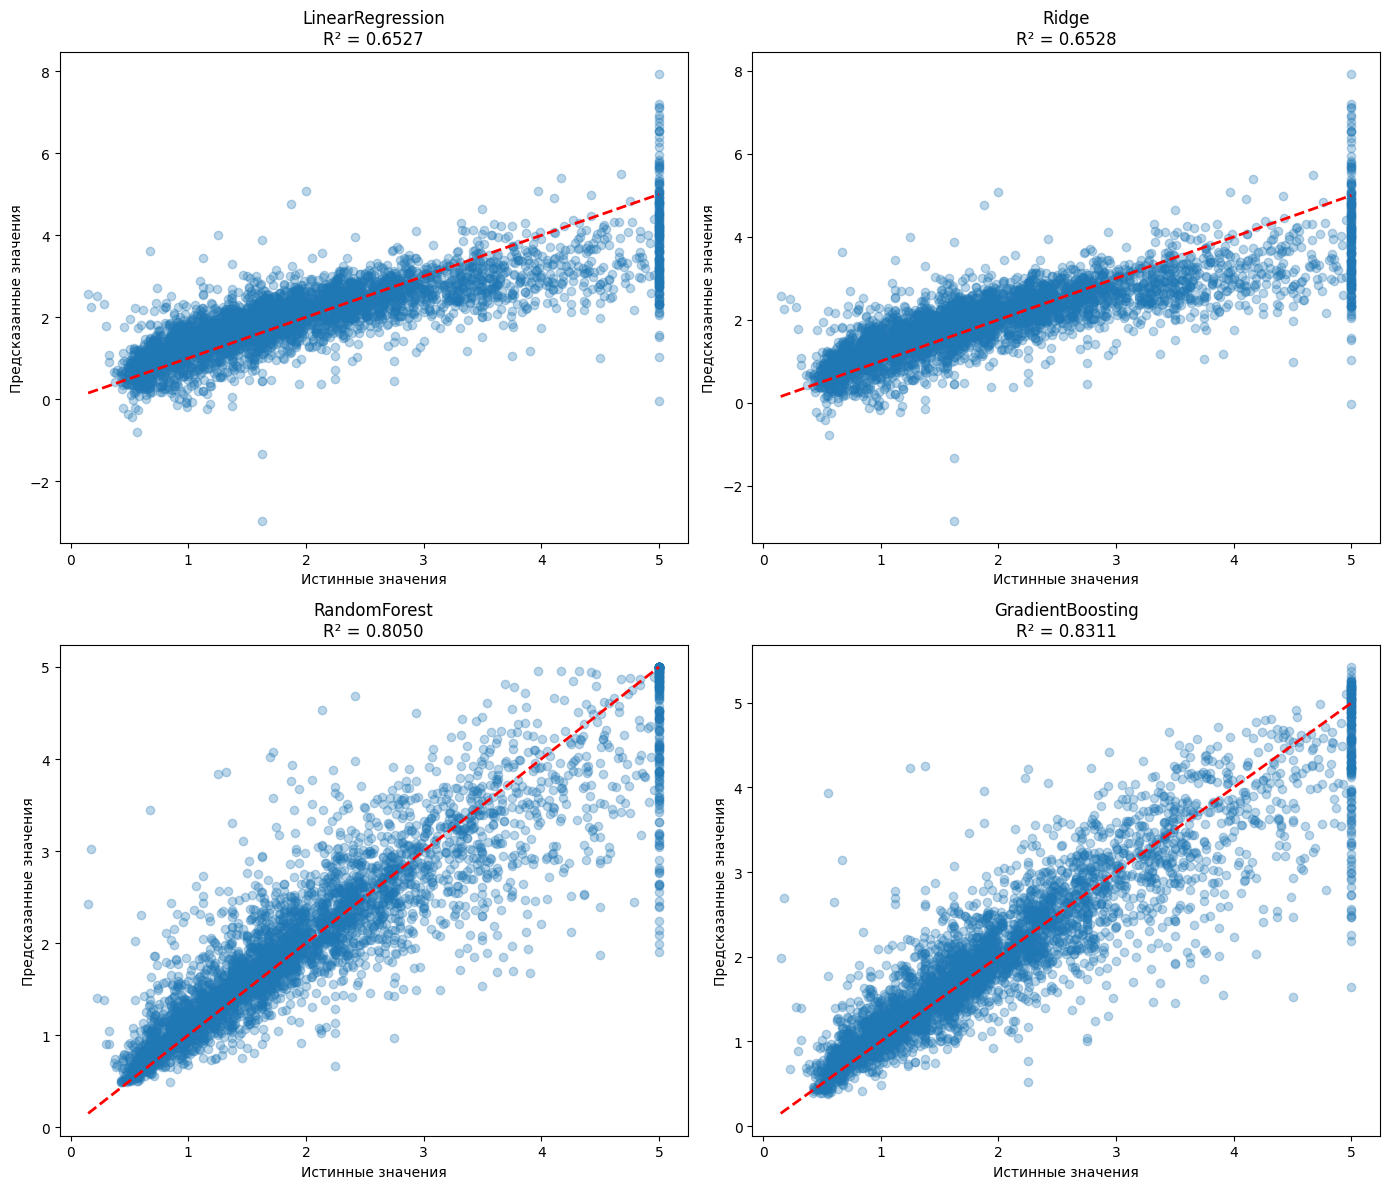

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    if name in ["LinearRegression", "Ridge"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    axes[idx].scatter(y_test, y_pred, alpha=0.3)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    axes[idx].set_xlabel("Истинные значения")
    axes[idx].set_ylabel("Предсказанные значения")
    axes[idx].set_title(f"{name}\nR² = {test_results[name]['r2']:.4f}")

plt.tight_layout()
plt.show()


### Мини-выводы блока 7:

- Все модели оценены на тестовой выборке по метрикам RMSE, R² и MAE
- Gradient Boosting показал наилучшие результаты: RMSE 0.4704, R² 0.8311, MAE 0.3112
- Линейные модели (Linear Regression, Ridge) быстрее в обучении и предсказании, но имеют меньшую точность
- Ансамблевые методы (Random Forest, Gradient Boosting) показывают лучшую точность, но требуют больше времени на обучение

## Выводы

**Результаты анализа:**

1. **Качество моделей**: Все четыре модели показали результаты на задаче регрессии для предсказания цен на жилье в Калифорнии. Коэффициент детерминации R² варьируется от 0.65 до 0.83, что указывает на хорошее качество моделей.

2. **Лучшая модель**: **Gradient Boosting Regressor** показала наилучшие результаты по всем метрикам точности:
   - RMSE: **0.4704** (наименьшая ошибка)
   - R²: **0.8311** (83.11% - объясняет 83% дисперсии)
   - MAE: **0.3112** (средняя абсолютная ошибка)
   - CV MSE: **0.2222** (кросс-валидация)
   - Время обучения: 13.50 сек
   - Время предсказания: 0.014 сек

3. **Сравнение моделей**:
   - **Gradient Boosting**: RMSE 0.4704, R² 0.8311 - лучшая модель по точности, хороший баланс времени обучения и предсказания
   - **Random Forest**: RMSE 0.5054, R² 0.8050 - вторая по качеству, но требует больше времени на обучение (23.91 сек)
   - **Ridge Regression**: RMSE 0.6746, R² 0.6528 - быстрая модель (0.006 сек обучение, 0.001 сек предсказание), но ниже точность
   - **Linear Regression**: RMSE 0.6746, R² 0.6527 - базовая модель, аналогична Ridge по точности

4. **Время обучения и предсказания**:
   - **Самые быстрые**: Ridge (0.006 сек обучение, 0.001 сек предсказание) и Linear Regression (0.018 сек обучение, 0.005 сек предсказание)
   - **Самые медленные**: Random Forest (23.91 сек обучение, 0.230 сек предсказание)
   - **Оптимальный баланс**: Gradient Boosting (13.50 сек обучение, 0.014 сек предсказание) - хорошая точность при разумном времени

5. **Особенности данных**: 
   - Датасет содержит 20,640 записей с 8 исходными признаками
   - После Feature Engineering количество признаков увеличено до 11
   - Наибольшая корреляция с целевой переменной у признака MedInc (0.688)
   - Пропущенных значений и дубликатов нет
   - Распределение целевой переменной близко к нормальному с небольшим правым хвостом

6. **Feature Engineering**: 
   - Созданные признаки (rooms_per_household, bedrooms_per_room, population_per_household) помогают лучше характеризовать данные
   - Новые признаки показывают различную корреляцию с целевой переменной, что улучшает качество регрессии
   - Использование новых признаков позволило улучшить качество моделей

7. **Анализ графиков предсказаний**: 
   - Графики "Истинные vs Предсказанные значения" показывают, что Gradient Boosting и Random Forest имеют лучшую линейную зависимость
   - Линейные модели (Linear Regression, Ridge) показывают больше рассеяния точек относительно идеальной линии
